# SWEATER

In [120]:
import pandas as pd
import numpy as np

from scipy import signal
import scipy.linalg as la
from scipy.stats import norm
from scipy.integrate import trapz
import math as m
import pywt

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from matplotlib.gridspec import GridSpec

## Load the original data

In [121]:
# original dataset
DF = pd.read_csv('4_Chest_sweater.txt',sep='\t')
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790


## Select only the meaningful data

We proceed as the previous dataset, noticing that the sample frequency of the dataset is Log Freq = 100 Hz. The interval in time we selected is $[10,140]s$.

Text(0, 0.5, 'Angular Velocity [dps]')

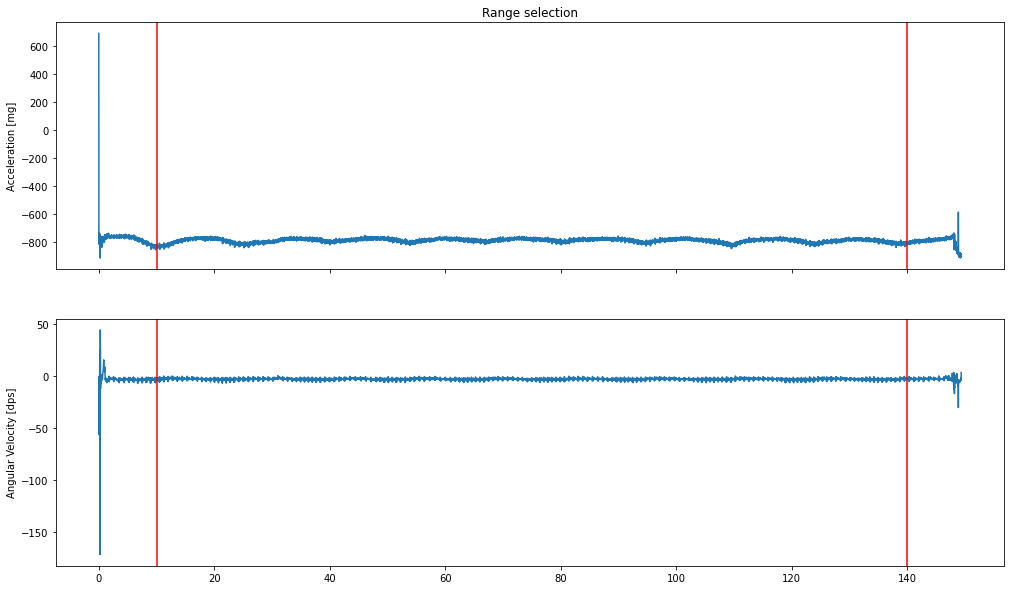

In [122]:
# plot raw data
(fig, (ax1,ax2)) = plt.subplots(2,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'])
ax1.axvline(x = 10, color = 'red')
ax1.axvline(x = 140, color = 'red')
ax1.set_ylabel('Acceleration [mg]')
ax1.set_title('Range selection')

ax2.plot(t, DF['GyroX'])
ax2.axvline(x = 10, color = 'red')
ax2.axvline(x = 140, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')



As we saw in the previous analysis of SCG dataset, the measurements of Accelerometer and Gyroscope better describe the system; thus we consider only this two sets for the analysis.

In [123]:
# new dataset with only the interesting data
a = 1000
b = 14000
freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk','MagnX','MagnY','MagnZ'], axis=1) 
df['Time'] = np.arange(0, len(df['AccX']))/freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-822.219,-105.957,579.012,-1.829268,0.609756,0.609756,0.00
1001,-818.498,-111.386,577.731,-2.682927,0.731707,0.731707,0.01
1002,-827.587,-108.214,577.670,-4.512195,0.609756,0.731707,0.02
1003,-829.600,-110.105,570.594,-3.536585,1.463415,0.731707,0.03
1004,-833.260,-108.824,563.701,-2.195122,1.341463,0.609756,0.04
...,...,...,...,...,...,...,...
13996,-807.213,-78.019,617.259,-2.682927,0.609756,0.365854,129.96
13997,-803.980,-72.041,616.344,-2.682927,1.219512,0.609756,129.97
13998,-803.065,-78.934,597.068,-2.804878,1.097561,0.243902,129.98
13999,-802.211,-79.788,614.697,-2.682927,1.829268,0.243902,129.99


## Calibration

In [124]:
# calibration matrices and offset vectors
gyro_off = np.array([-2.804399, 1.793105, 0.3411708])
acc_cal = np.array([[1.002982, 9.415505E-05, 0.004346743],
                    [9.04459E-05, 1.002731, -0.001444198], 
                    [0.004346536, -0.001444751,	1.030587]])
acc_off = np.array([3.602701, -20.96658, 54.97186])

In [125]:
# calibration procedure
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_off.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_cal.T) + acc_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-818.561316,-128.123523,648.273377,-4.633667,2.402861,0.950927,0.00
1001,-814.835299,-133.565163,646.977212,-5.487326,2.524812,1.072878,0.01
1002,-823.951369,-130.385234,646.870258,-7.316594,2.402861,1.072878,0.02
1003,-826.001308,-132.271361,639.571807,-6.340984,3.256520,1.072878,0.03
1004,-829.702063,-130.977239,632.450211,-4.999521,3.134568,0.950927,0.04
...,...,...,...,...,...,...,...
13996,-803.341688,-100.163103,687.715099,-5.487326,2.402861,0.707024,129.96
13997,-800.102461,-94.167163,686.777527,-5.487326,3.012617,0.950927,129.97
13998,-799.269170,-101.051067,666.925868,-5.609277,2.890666,0.585073,129.98
13999,-798.336075,-101.932782,685.099032,-5.487326,3.622373,0.585073,129.99


## Statistical analysis:

Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [126]:
# statistical descriptors
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
mean,-782.610405,-94.627886,707.983191,-5.620871,3.297117,0.622097
median,-780.100191,-94.335121,711.157509,-5.609277,3.256520,0.585073
variance,198.130373,180.768600,491.788827,0.641299,0.901328,0.056764
standard deviation,14.075879,13.445021,22.176312,0.800812,0.949383,0.238252
25% percentile,-791.461692,-103.978008,694.757991,-5.975131,2.646764,0.463122
75% percentile,-772.174827,-84.323690,723.607053,-5.121472,3.866276,0.828976


We use the mean to center the data around 0 in the y-axis.

Correlation coefficients:

In [127]:
# corr.coeff.
M = df.loc[:,:'GyroZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
AccX,1.000000,0.728544,0.721530,-0.039568,0.051239,0.009302
AccY,0.728544,1.000000,0.718113,-0.029258,0.045958,-0.029860
AccZ,0.721530,0.718113,1.000000,-0.034282,0.008241,-0.031668
GyroX,-0.039568,-0.029258,-0.034282,1.000000,-0.524570,0.489724
GyroY,0.051239,0.045958,0.008241,-0.524570,1.000000,-0.548018
GyroZ,0.009302,-0.029860,-0.031668,0.489724,-0.548018,1.000000


With respect to the previous dataset, the correlation coefficients among the components of the same instrument are more relevant. This is probably due to the oscillation we can see in the following plot.

Text(0.5, 0, 'Time(s)')

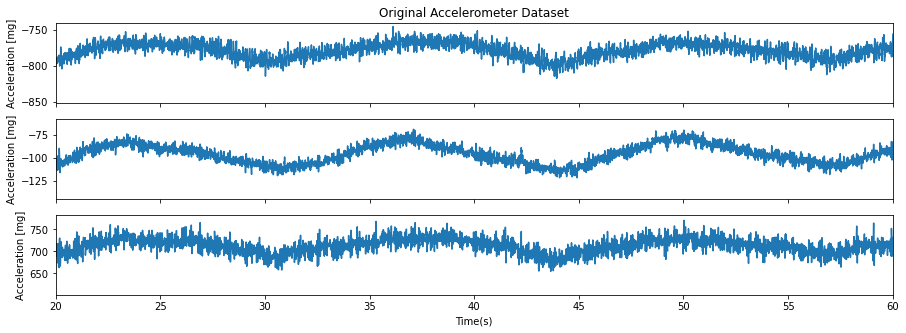

In [128]:
# principal component plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,5),sharex=True)
ax[0].plot(df['Time'],df['AccX'])
ax[0].set_ylabel('Acceleration [mg]')

ax[0].set_title('Original Accelerometer Dataset')

ax[1].plot(df['Time'],df['AccY'])
ax[1].set_ylabel('Acceleration [mg]')
ax[2].plot(df['Time'],df['AccZ'])
ax[2].set_ylabel('Acceleration [mg]')

ax[2].set_xlim(20,60)
ax[2].set_xlabel('Time(s)')


We can see that the same oscillation is present in all the components of the accelerometer and gyroscope, with a period around $15s$. For this reason the components correlations are more relevant, and this affects also the variability of the dataset.

After centering the data, we designed a filter to remove this low frequencies component.

## Centering the data

In [129]:
# centered dataset
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Time
1000,-35.950911,-33.495636,-59.709814,0.987204,-0.894256,0.328830,0.00
1001,-32.224895,-38.937276,-61.005979,0.133545,-0.772305,0.450781,0.01
1002,-41.340965,-35.757348,-61.112933,-1.695723,-0.894256,0.450781,0.02
1003,-43.390903,-37.643475,-68.411384,-0.720113,-0.040597,0.450781,0.03
1004,-47.091659,-36.349353,-75.532980,0.621350,-0.162549,0.328830,0.04
...,...,...,...,...,...,...,...
13996,-20.731283,-5.535217,-20.268092,0.133545,-0.894256,0.084928,129.96
13997,-17.492057,0.460723,-21.205664,0.133545,-0.284500,0.328830,129.97
13998,-16.658765,-6.423181,-41.057323,0.011594,-0.406451,-0.037023,129.98
13999,-15.725670,-7.304895,-22.884159,0.133545,0.325256,-0.037023,129.99


In [130]:
#filtering low frequencies (cut-off frequency=0.1)
Sig = dfc.values[:,:-1].T
n_Sig = np.zeros_like(Sig)
for i in range(Sig.shape[0]):
    ft = np.fft.rfft(Sig[i])
    f = np.fft.rfftfreq(len(Sig[i]), 1/freq)
    ft[f < 0.1] = 0
    n_Sig[i] = np.fft.irfft(ft, len(Sig[i]))

dfn = pd.DataFrame(n_Sig.T, columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'])

After this filter we recalculated the variance and the correlation matrix, and we can see that they decreased.

In [133]:
# variance
stat_dfn = pd.DataFrame({'variance': dfn.var()}).T
stat_dfn

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
variance,54.602597,20.949014,187.926273,0.524324,0.69157,0.049929


In [135]:
# correlation coefficients
M = dfn.loc[:,:'GyroZ'].corr()  
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
AccX,1.000000,0.294988,0.172427,0.009658,0.014608,0.050421
AccY,0.294988,1.000000,0.303391,0.076325,0.015768,-0.002925
AccZ,0.172427,0.303391,1.000000,0.022885,-0.070615,-0.019341
GyroX,0.009658,0.076325,0.022885,1.000000,-0.411272,0.406293
GyroY,0.014608,0.015768,-0.070615,-0.411272,1.000000,-0.470671
GyroZ,0.050421,-0.002925,-0.019341,0.406293,-0.470671,1.000000


## PCA

In [136]:
N = dfn.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfn[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfn[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

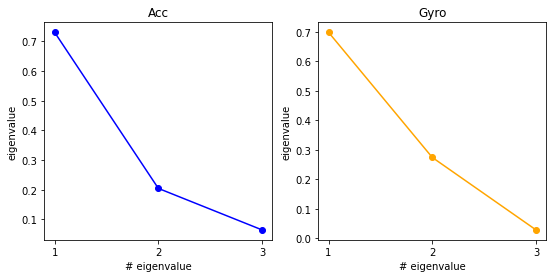

In [137]:
#Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = 'blue', marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = 'orange', marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

In [138]:
print('Eigenvalues and eigenvectors (Acc): \n', avl_acc, '\n\n',U_acc, '\n')
print('Eigenvalues and eigenvectors (Gyro): \n', avl_gyro, '\n\n',U_gyro, '\n')

Eigenvalues and eigenvectors (Acc): 
 [192.54927235  53.90214694  17.02646402] 

 [[-0.13307117  0.96680284  0.21813832]
 [-0.11691521  0.20324628 -0.97212231]
 [-0.98418641 -0.15486514  0.08598773]] 

Eigenvalues and eigenvectors (Gyro): 
 [0.8836895  0.34657325 0.03555983] 

 [[-0.57865026 -0.81143569 -0.08207317]
 [ 0.80513527 -0.58439334  0.10120093]
 [-0.13008106 -0.00752007  0.99147484]] 



From PCA we can see that for the accelerometer Z-component is the most relevant, for gyroscope it is Y.

We notice that the first principal component contains about $70 \%$ of variability, so in the following analysis we will consider only this one for each instrument.
Thus, data was rotated according to the new axes:

In [139]:
# rotated dataset after PCA
rot = np.dot(dfn[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfn[['GyroX','GyroY','GyroZ']],U_gyro)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2]})
dfr['Time'] = df['Time'].values
dfr

,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Time
0,15.491248,-5.080693,7.154127,-0.892206,-0.347657,0.184328,0.00
1,16.870863,-2.368021,13.107089,-0.312097,0.272442,0.387695,0.01
2,17.781577,-10.503280,7.979827,0.652035,1.827638,0.525539,0.02
3,25.422653,-11.723227,8.700495,0.778619,0.536716,0.531909,0.03
4,32.738114,-13.920504,5.984763,-0.076136,-0.480014,0.288608,0.04
...,...,...,...,...,...,...,...
12996,-28.430115,9.125879,-13.122464,-0.385621,0.348900,0.012301,129.96
12997,-28.678783,13.638517,-18.364018,0.077415,-0.009679,0.315886,129.97
12998,-8.485874,16.136148,-13.235909,0.101210,0.162888,-0.049128,129.98
12999,-26.430925,14.061175,-10.651135,0.623588,-0.364079,0.014966,129.99


Text(0.5, 0, 'Time(s)')

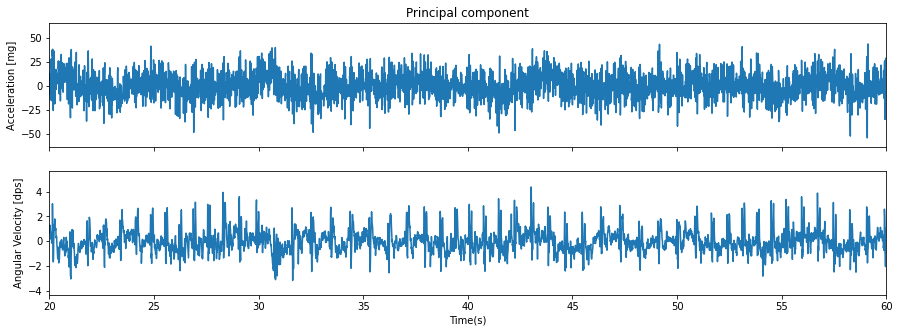

In [140]:
# principal component plots
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,5),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'])
ax[0].set_ylabel('Acceleration [mg]')
ax[0].set_title('Principal component')
ax[1].plot(dfr['Time'],dfr['Gyro1'])
ax[1].set_ylabel('Angular Velocity [dps]')


ax[1].set_xlim(20,60)
ax[1].set_xlabel('Time(s)')


## FFT analysis

For each principal component, we performed the FFT to higlight the heart beat frequency between 40 BPM and 100 BPM.

Text(0, 0.5, 'Amplitude')

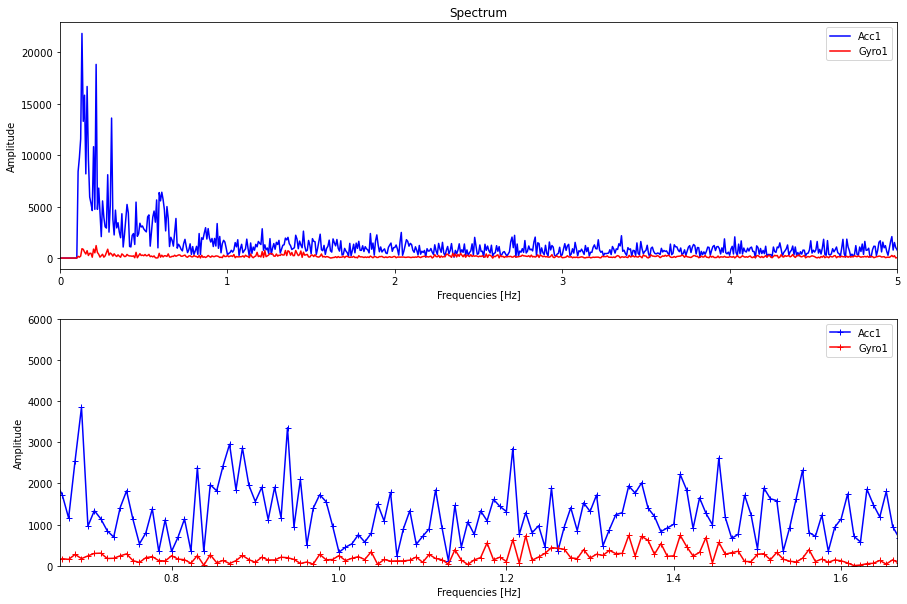

In [141]:
# HeartBeat freq
min_f=40./60.
max_f=100./60.

# FFT
A1_FFT = np.abs(np.fft.rfft(dfr['Acc1']))
G1_FFT = np.abs(np.fft.rfft(dfr['Gyro1']))
freq_FFT = np.fft.rfftfreq(d=1/freq, n=len(dfr['Acc1']))

# spectrum
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,10))
ax1.plot(freq_FFT, A1_FFT,'b-', label='Acc1')
ax1.plot(freq_FFT, G1_FFT,'r-', label='Gyro1')
ax1.set_xlim(0,5)
ax1.legend(loc='best')
ax1.set_xlabel('Frequencies [Hz]')
ax1.set_title('Spectrum')
ax1.set_ylabel('Amplitude')

ax2.plot(freq_FFT, A1_FFT,'b-+', label='Acc1')
ax2.plot(freq_FFT, G1_FFT,'r-+', label='Gyro1')
ax2.set_xlim(min_f, max_f)
ax2.set_ylim(0,6000)
ax2.legend(loc='best')
ax2.set_xlabel('Frequencies [Hz]')
ax2.set_ylabel('Amplitude')

In this case applying the pure FFT does not give a clear result. The spectrum does not display any particular frequence peak that can suggest the right heart beat, in both gyroscope and accelerometer. We need to proceed with the analysis, in order to extract results from this dataset.

## SIGNAL PROCESSING

As before, our signal processing pipeline is the following:

- Discrete wavelet transform
- Signal envelope
- Bandpass filter (40-200)BPM 


In [22]:
sigA = dfr['Acc1']
sigG = dfr['Gyro1']
t = dfr['Time']

In [23]:
# wavelet
def wavelet_decomposition(t, signal, n, wave_name, color):
    coeff = pywt.wavedec(signal, wave_name, level = n)
    sigs = np.zeros((n+1,len(t)+1))
    for i in range(n+1):
        ca = coeff.copy()
        for j in range(n+1):
            if j != i: 
                ca[j] = np.zeros_like(ca[j])
        sigs[i] = pywt.waverec(ca, wave_name)
    ax = []
    fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
    ax[n].set_xlabel('Time [s]')
    for i in range(n+1):
        ax[i].plot(t, sigs[i][:-1], color = color)
    return coeff

In [24]:
# bandpass filter
def FILTER(SIG,f1,f2):
    FFT = np.fft.rfft(SIG)
    freq = np.fft.rfftfreq(len(SIG), 1/100)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = np.fft.irfft(new_FFT, len(SIG))
    return new_SIG


 ## Gyroscope

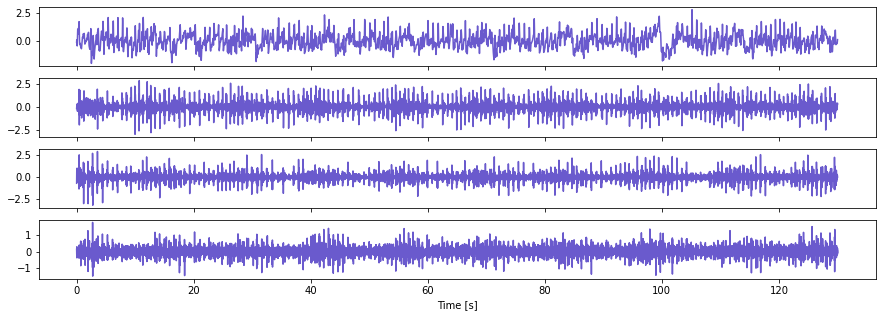

In [25]:
n=3
wave_name='sym4'
CG = wavelet_decomposition(t, sigG, n, wave_name , 'slateblue')


Text(0.5, 1.0, 'Wavelet Filtered Signal')

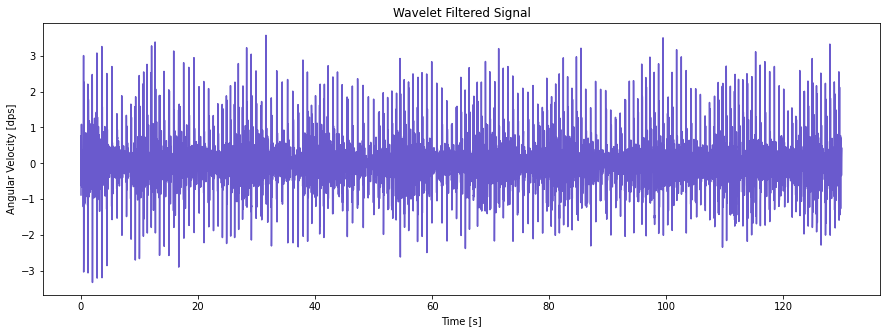

In [26]:
# filtered signal after wavelet decomposition
cg = CG.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        cg[j] = np.zeros_like(cg[j])
sigG_w = pywt.waverec(cg, wave_name)
SIGG = sigG_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGG, color = 'slateblue')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [dps]')
plt.title('Wavelet Filtered Signal')

Text(0.5, 0, 'Time [s]')

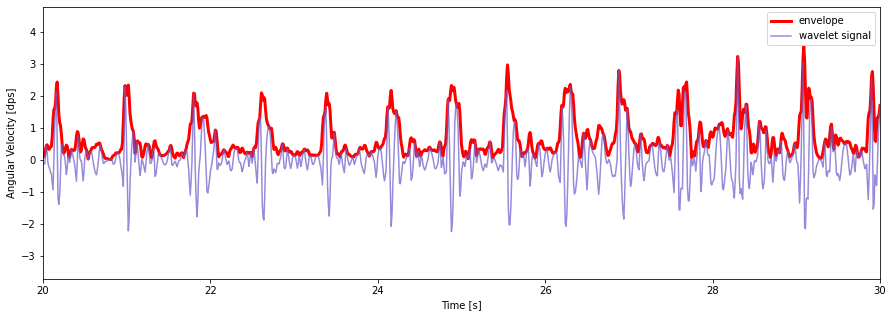

In [27]:
# envelope
SIGG_h = np.abs(signal.hilbert(SIGG))

plt.figure(figsize=(15,5))
plt.plot(t, SIGG_h, color = 'r', linewidth=3, label='envelope')
plt.plot(t, SIGG, 'slateblue', alpha=0.7, label='wavelet signal')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')

Text(0.5, 1.0, 'Filtered Signal')

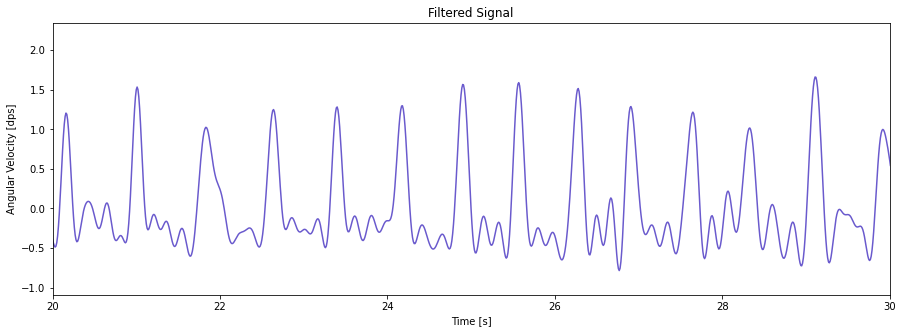

In [66]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_G = FILTER(SIGG_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_G , 'slateblue')
plt.xlim(20, 30)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Accelerometer

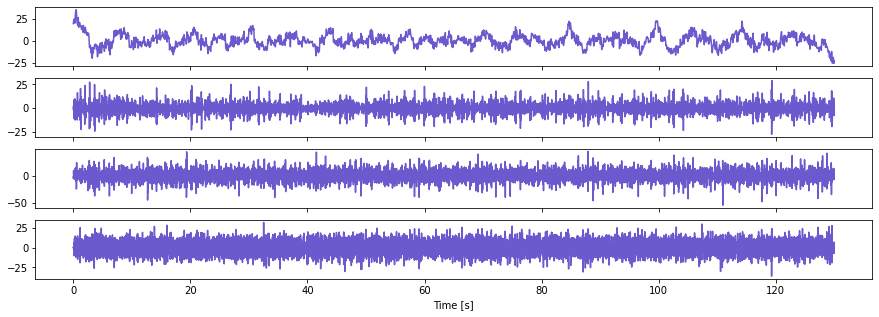

In [33]:
CA = wavelet_decomposition(t, sigA, n, wave_name,'slateblue')


Text(0.5, 1.0, 'Wavelet Filtered Signal')

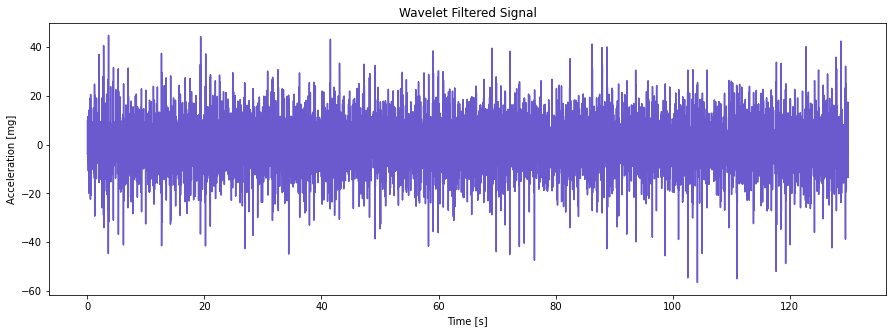

In [67]:
# filtered signal after wavelet decomposition
ca = CA.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigA_w = pywt.waverec(ca, wave_name)
SIGA = sigA_w[:-1]

plt.figure(figsize=(15,5))
plt.plot(t, SIGA, color = 'slateblue')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mg]')
plt.title('Wavelet Filtered Signal')

Text(0.5, 0, 'Time [s]')

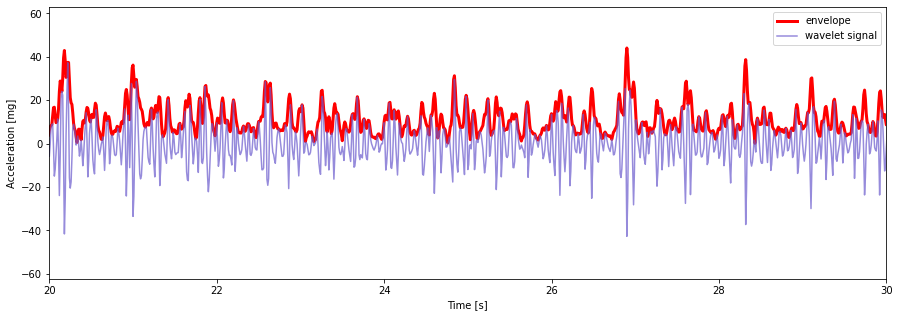

In [68]:
# envelope
SIGA_h = np.abs(signal.hilbert((SIGA)))

plt.figure(figsize=(15,5))
plt.plot(t, SIGA_h, color = 'r', linewidth=3, label='envelope')
plt.plot(t, SIGA, 'slateblue', alpha=0.7, label='wavelet signal')
plt.legend(loc='best')
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')

Text(0.5, 1.0, 'Filtered Signal')

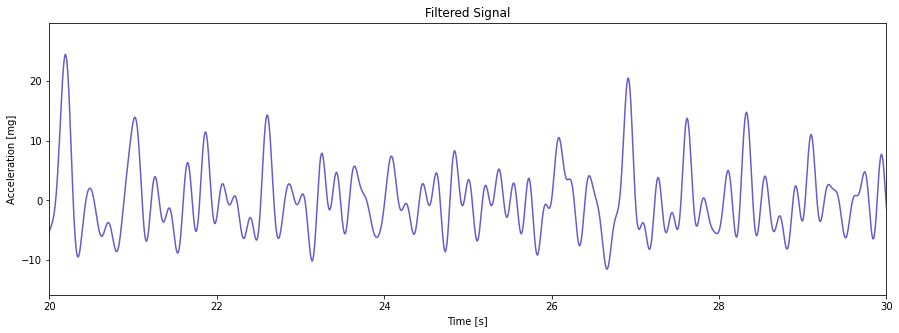

In [93]:
# signal filtered with bandpass filter
f1 = 0.66
f2 = 6

signal_A = FILTER(SIGA_h,f1,f2)

plt.figure(figsize=(15,5))
plt.plot(t, signal_A , 'slateblue')
plt.xlim(20, 30)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.title('Filtered Signal')

## Find peaks

In [59]:
# function to plot HRV and BPM histo
def histo_func(bins1,peaks1,t):
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,marker='o')
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart BPM as a function of time and histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal')
    bin_center1=(b1[1:]+b1[:-1])*0.5
    ax_marg.set_ylim(l)

In [142]:
# function to fix peaks

##ADD ITERATIONS PARAMETER
def to_fix_peaks(time,peaks,data,thr,r=0.5):
    
    peaks_time=time[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    #rate = 1/period*60
    
    peaks_new=peaks.copy()
    diff_mean=np.mean(np.abs(period[1:]-period[:-1]))
    for i in np.arange(1,len(period)-1):
        
        peaks_time=time[peaks_new]
        period = peaks_time[1:]-peaks_time[:-1]    
        to_check=np.abs(period[i]-period[i+1])
        
        if to_check>1.5*(diff_mean):
            if thr==None: new_thr=-m.inf
            else:  new_thr=0.33*(thr+data[peaks_new[i+1]])
                
            if period[i]-period[i+1]>0:
                array=data[(time<time[peaks_new[i+1]]) & (time>time[peaks_new[i+1]]-r)]
                der = array[1:]-array[:-1]
                change=[]
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1]-len(array)+change[-1]
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1]                    
                
            if period[i]-period[i+1]<0: #
                array=data[(time>time[peaks_new[i+1]]) & (time<time[peaks_new[i+1]]+r)]
                der = array[1:]-array[:-1]
                change=np.array([])
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks_new[i+1] + change[0] +1
                    peaks_time=time[peaks_new]
                    period = peaks_time[1:]-peaks_time[:-1]
                if np.abs(period[i]-period[i+1])>to_check:
                    peaks_new[i+1]= peaks[i+1] 
                
    plt.figure(figsize=(10,4))
    plt.plot(time,data)
    #plt.plot(time,sigA,color='grey',alpha=0.5)
    plt.plot(time[peaks],data[peaks], 'rx', label='old peaks')
    plt.plot(time[peaks_new],data[peaks_new], 'gx', label='new peaks')
    plt.legend(loc='upper right')
    return peaks_new

Text(0.5, 1.0, 'Peaks Detection')

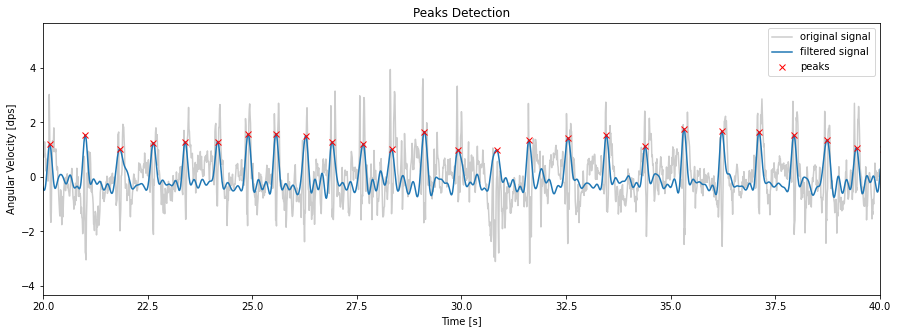

In [72]:
# gyroscope peaks
plt.figure(figsize=(15,5))
plt.plot(t,sigG, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_G,label='filtered signal')
peaksG,_ = signal.find_peaks(signal_G, height=0.3 , distance=50)
plt.plot(t[peaksG],signal_G[peaksG], 'rx', label='peaks')
plt.xlim(20,40)
plt.ylabel('Angular Velocity [dps]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

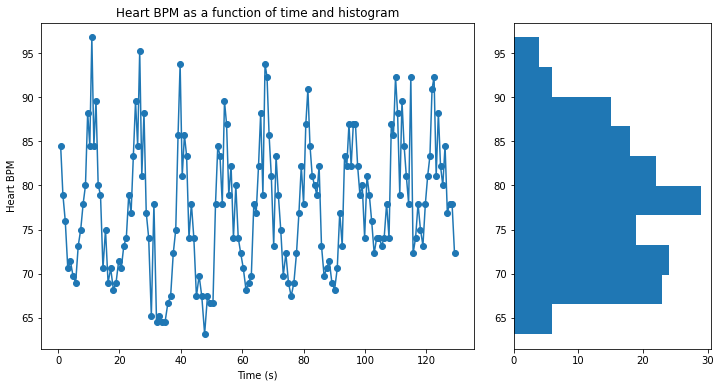

In [87]:
# HRV and BPM histo
histo_func(10,peaksG,t.values)

Text(0.5, 1.0, 'Peaks Detection')

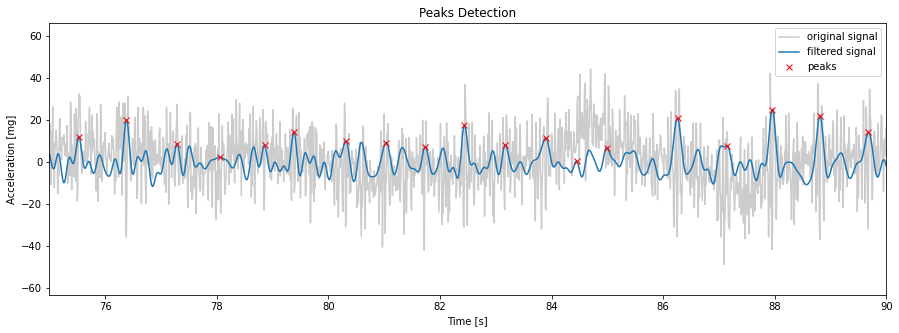

In [118]:
# accelerometer
plt.figure(figsize=(15,5))
plt.plot(t,sigA, color='grey',alpha=0.4,label='original signal')
plt.plot(t,signal_A,label='filtered signal')
peaksA,_ = signal.find_peaks(signal_A, height=0 , distance=52)
plt.plot(t[peaksA],signal_A[peaksA], 'rx', label='peaks')
plt.xlim(75,90)
plt.ylabel('Acceleration [mg]')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.title('Peaks Detection')

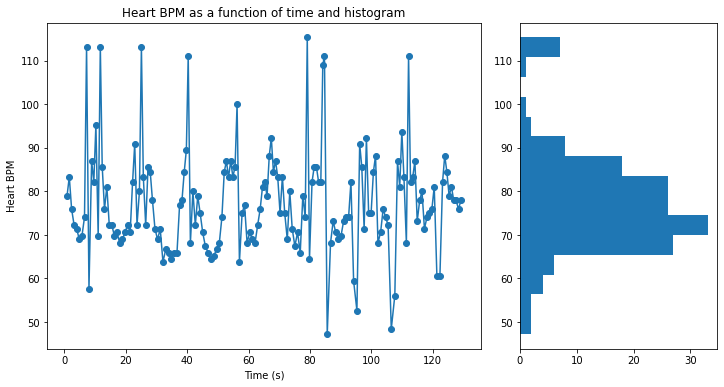

In [96]:
# HRV and BPM histo
histo_func(15,peaksA,t.values)

In [145]:
# fixed peaks for the accelerometer

peaks_new_A = to_fix_peaks(t.values,peaksA,signal_A,thr=None,r=0.4)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

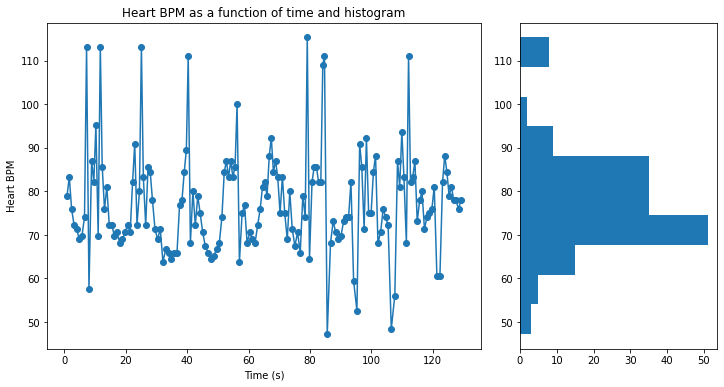

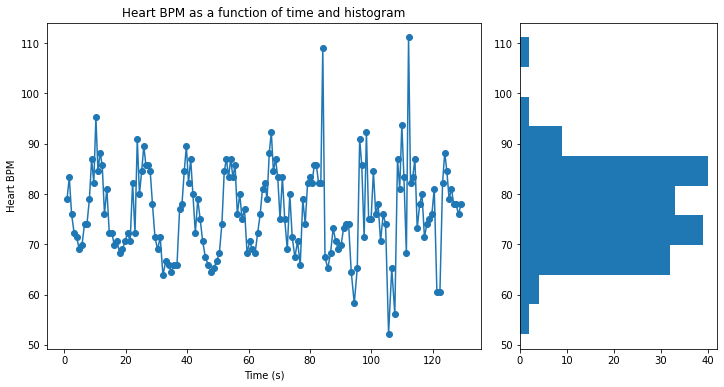

In [98]:

histo_func(10,peaksA,t.values)
histo_func(10,peaks_new_A,t.values)


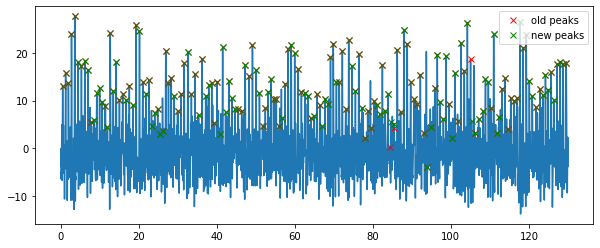

In [110]:
# fixed peaks for the accelerometer
%matplotlib inline
peaks_new2_A = to_fix_peaks(t.values,peaks_new_A,signal_A,thr=None,r=0.4)

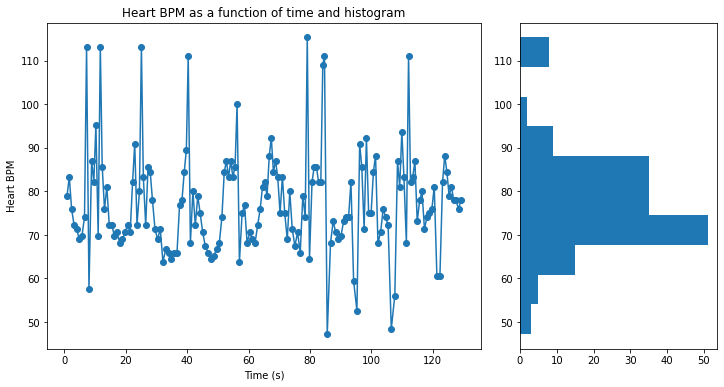

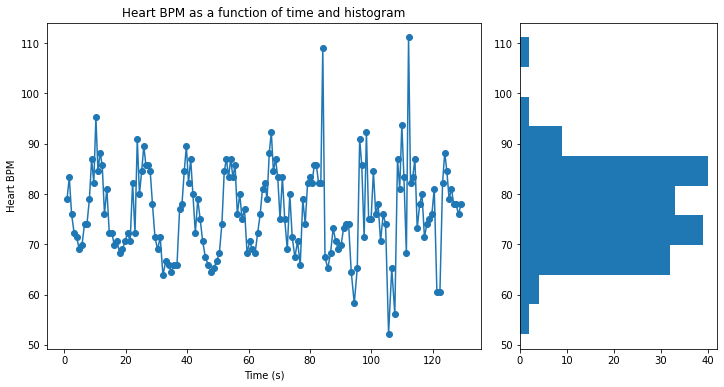

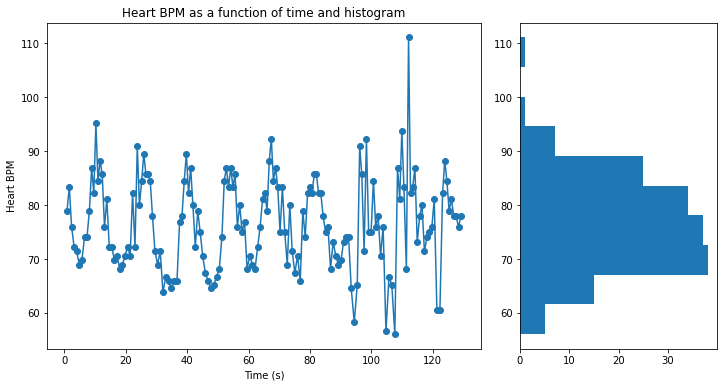

In [111]:

histo_func(10,peaksA,t.values)
histo_func(10,peaks_new_A,t.values)
histo_func(10,peaks_new2_A,t.values)

# Peaks errors and KDE

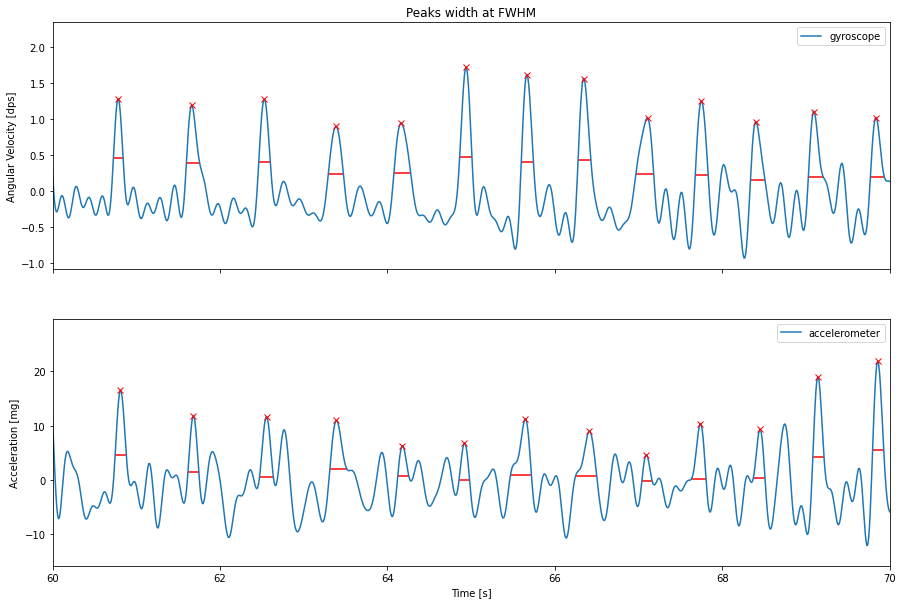

In [113]:
# gyroscope
widthsG = signal.peak_widths(signal_G, peaksG, rel_height=0.5)
# accelerometer
widthsA = signal.peak_widths(signal_A, peaks_new2_A, rel_height=0.5)

fig, ax = plt.subplots(2,1, figsize=(15,10),sharex=True)
ax[0].plot(t.values,signal_G,label='gyroscope')
ax[0].plot(t.values[peaksG], signal_G[peaksG],'rx')
ax[0].hlines(widthsG[1],xmin=0.01*widthsG[2],xmax=0.01*widthsG[3],color='red')
ax[0].set_xlim(30,40)
ax[0].set_ylabel('Angular Velocity [dps]')
ax[0].set_title('Peaks width at FWHM')
ax[0].legend()
ax[1].plot(t.values,signal_A,label='accelerometer')
ax[1].plot(t.values[peaks_new2_A], signal_A[peaks_new2_A],'rx')
ax[1].hlines(widthsA[1],xmin=0.01*widthsA[2],xmax=0.01*widthsA[3],color='red')
ax[1].set_xlim(60,70)
ax[1].set_ylabel('Acceleration [mg]')
ax[1].set_xlabel('Time [s]')
ax[1].legend()

plt.show()


In [81]:
# KDE gyroscope
#uncertainties as unc
def kde_func(widths,time,peaks):
    const = 2*(2*np.log(2))**0.5
    sigma = widths[0]/const*0.01

    #peaks_time=np.array([unc.ufloat(t.values[peaksG][i],sigma[i]) for i in range(len(peaksG))])
    peaks_time=np.array(time.values[peaks])

    period = peaks_time[1:] - peaks_time[:-1]
    sigma_period = (sigma[1:]**2 + sigma[:-1]**2)**0.5
    rate = 1/period*60
    err_rate = rate/period*sigma_period
    #rate_val=np.array([rate[i].n for i in range(len(rate))])
    #rate_err=np.array([rate[i].s for i in range(len(rate))])

    #KDE 
    xx = np.linspace(min(rate),max(rate),1000)
    fx = np.zeros(xx.shape)
    for r,s in zip(rate,err_rate*1.06*err_rate.size**(-1/5)):
        fx += norm.pdf(xx,r,s)
    fx = fx/trapz(fx,xx)
    return xx,fx,rate,err_rate

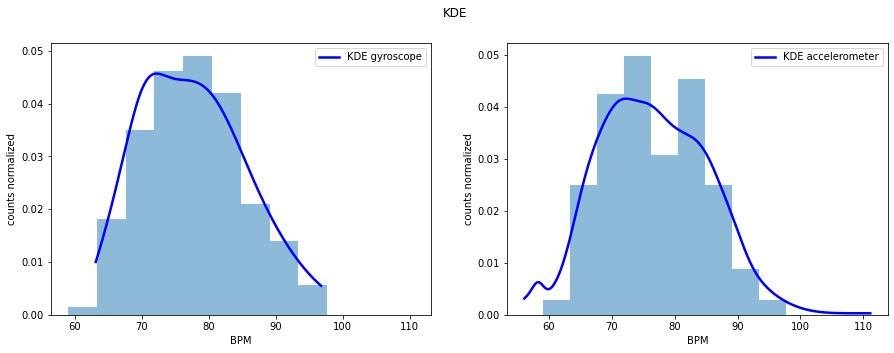

In [114]:
xxG,fxG,rateG,err_rateG = kde_func(widthsG,t,peaksG)
xxA,fxA,rateA,err_rateA = kde_func(widthsA,t,peaks_new2_A)
fig,ax=plt.subplots(1,2,figsize=(15,5))

bins=np.arange(59,111,4.3)
ax[0].hist(rateG, bins=bins, density=True, alpha=0.5)
ax[0].plot(xxG, fxG, linewidth=2.5, linestyle='solid',color='blue',label='KDE gyroscope')
ax[0].set_xlabel('BPM')
ax[0].set_ylabel('counts normalized')
ax[0].legend()
ax[1].hist(rateA, bins=bins, density=True, alpha=0.5)
ax[1].plot(xxA, fxA, linewidth=2.5, linestyle='solid',color='blue',label='KDE accelerometer')
ax[1].set_xlabel('BPM')
ax[1].set_ylabel('counts normalized')
ax[1].legend()
fig.suptitle('KDE')
plt.show()


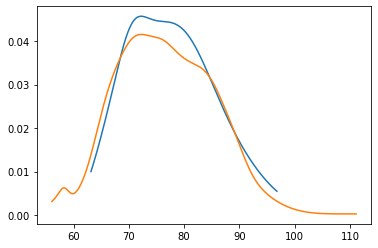

In [115]:
plt.plot(xxG, fxG)
plt.plot(xxA, fxA)

In [116]:
medianaG=np.median(rateG)
print(medianaG)

medianaA=np.median(rateA)
print(medianaA)


meanG=np.average(rateG,weights=err_rateG)
print(meanG)

meanA=np.average(rateA,weights=err_rateA)
print(meanA)

print(len(peaks_new_A),len(peaksG))

77.92207792207773
75.94936708860759
79.42328279208658
78.17375171507337
164 167


(75.0, 90.0)

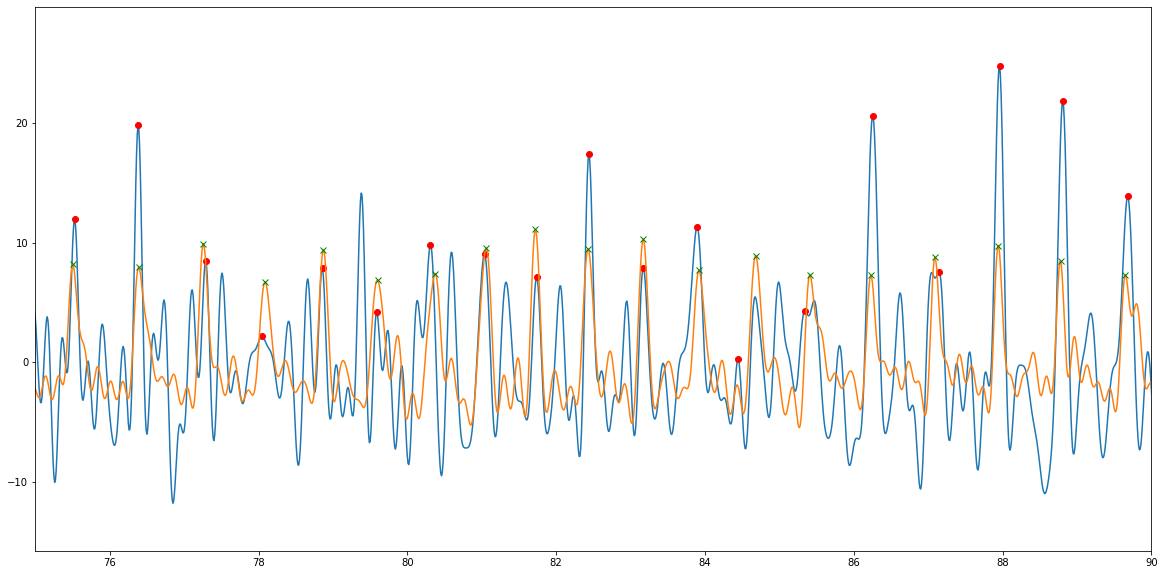

In [117]:
plt.figure(figsize=(20,10))
plt.plot(t,signal_A,label='filtered signal')
plt.plot(t[peaks_new_A],signal_A[peaks_new_A], 'ro', label='peaks')

plt.plot(t,signal_G*7,label='filtered signal')
plt.plot(t[peaksG],signal_G[peaksG]*7, 'gx', label='peaks')
plt.xlim(75,90)

## Results

- grafico dei picchi diversi per confronto
- stima con la media di heart beat
- trovare errore da associare alla media e alle distanze singole TUTTI
- heart rate variabiltity 2 in 1 ELE + MAR (migliorare histofunc)



- colore all'istogramma (dall'inizio!)--> Marika <3 (NO rosa o viola strani)
- modificare fix peaks per iterazioni ALE LOR
- sternum battito ingrandito ELE
- sternum mettere 3 wavelet e non due, con n=4 ALE LOR
- agg cit articolo2
- sternum bins uguali e ultima parte ELE